# Toronto Neighborhoods Clustering

In [351]:
from bs4 import BeautifulSoup
import pandas as pd
import requests
import numpy as np

from geopy.geocoders import Nominatim

# Matplotlib and associated plotting modules
import matplotlib.cm as cm
import matplotlib.colors as colors

# import k-means from clustering stage
from sklearn.cluster import KMeans

# map rendering library
import folium 

from sklearn.cluster import KMeans
from scipy.spatial.distance import cdist

import matplotlib.pyplot as plt

from collections import Counter

from sklearn.metrics import silhouette_samples, silhouette_score

%matplotlib inline

from sklearn.preprocessing import StandardScaler

## 1. Functions definition

Function for extract venues

Each row is in a tag 'tr'. For each row, columns are divided by 'td'. Data is already ordered by postal code.

In [352]:
def getNearbyVenues(names, latitudes, longitudes, radius=500):
    
    venues_list=[]
    for name, lat, lng in zip(names, latitudes, longitudes):
        print(name)
            
        # create the API request URL
        url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION, 
            lat, 
            lng, 
            radius, 
            LIMIT)
            
        # make the GET request
        results = requests.get(url).json()["response"]['groups'][0]['items']
        
        # return only relevant information for each nearby venue
        venues_list.append([(
            name, 
            lat, 
            lng, 
            v['venue']['name'], 
            v['venue']['location']['lat'], 
            v['venue']['location']['lng'],  
            v['venue']['categories'][0]['name']) for v in results])

    nearby_venues = pd.DataFrame([item for venue_list in venues_list for item in venue_list])
    nearby_venues.columns = ['Neighborhood', 
                  'Neighborhood Latitude', 
                  'Neighborhood Longitude', 
                  'Venue', 
                  'Venue Latitude', 
                  'Venue Longitude', 
                  'Venue Category']
    
    return(nearby_venues)

Function to populare dataframe

In [353]:
def getTorontoDataFrame(wikiTableIn):
    count=0
    countList=0
    listFields=[]
    oldPostCode=''
    
    for rowWiki in wikiTableIn.find_all('tr'):
        listTmp=[]
        if count!=0:
            for fieldsWiki in rowWiki.find_all('td'):
                listTmp.append(fieldsWiki.get_text().replace('\n',''))
                
        if len(listTmp)>0:
            postCode=listTmp[0]
            borough=listTmp[1]
            neighborhood=listTmp[2]
            
            #Discard record with Borough in Not assigned
            if borough!='Not assigned':
                #Assign the value of Borough to Neighborhood if it is not assigned
                if neighborhood=='Not assigned':
                    listTmp[2]=listTmp[1]
                #Compact on post code
                if oldPostCode==postCode:
                    oldNeighborhood=listFields[countList-1][2]
                    listTmp[2]=str(oldNeighborhood)+', '+str(neighborhood)
                listFields.append(listTmp)
                countList=countList+1
            
            #Assign new post code
            oldPostCode=postCode
    
        count=count+1
    
    #Create DataFrame
    labels = ['PostalCode','Borough','Neighborhood']
    dfInput = pd.DataFrame.from_records(listFields, columns=labels)
    
    #Remove duplicates on postal code (keep last, the one with more records)
    dfInput.drop_duplicates(subset=['PostalCode'], keep='last', inplace=True)
    
    return(dfInput)

Function for returning most common venues

In [354]:
def return_most_common_venues(row, num_top_venues):
    row_categories = row.iloc[1:]
    row_categories_sorted = row_categories.sort_values(ascending=False)
    
    return row_categories_sorted.index.values[0:num_top_venues]

In [355]:
def k_means_find_best_k(df,k_max):
    app={}
    for k in range (2, k_max):
        #Create a kmeans model on our data, using k clusters.  random_state helps ensure that the algorithm returns the same results each time.
        kmeans_model = KMeans(init="k-means++", n_init=12, n_clusters=k, random_state=10).fit(df)
    
        # These are our fitted labels for clusters -- the first cluster has label 0, and the second has label 1.
        labels = kmeans_model.labels_
        cluster_labels=kmeans_model.fit_predict(df)
        # Sum of distances of samples to their closest cluster center
        dist=sum(np.min(cdist(df, kmeans_model.cluster_centers_, 'euclidean'), axis=1)) / df.shape[0]
        #dist=kmeans_model.inertia_
        #dist=kmeans_model.score(df)
        app[k]= dist

    return(app)

In [356]:
def chooseKSilhouette(X,k_max):
    #range_n_clusters = [2, 3, 4, 5, 6]
    
    for n_clusters in range(2,k_max):
        # Create a subplot with 1 row and 2 columns
        fig, (ax1, ax2) = plt.subplots(1, 2)
        fig.set_size_inches(18, 7)
    
        # The 1st subplot is the silhouette plot
        # The silhouette coefficient can range from -1, 1 but in this example all
        # lie within [-0.1, 1]
        ax1.set_xlim([-0.1, 1])
        # The (n_clusters+1)*10 is for inserting blank space between silhouette
        # plots of individual clusters, to demarcate them clearly.
        ax1.set_ylim([0, len(X) + (n_clusters + 1) * 10])
    
        # Initialize the clusterer with n_clusters value and a random generator
        # seed of 10 for reproducibility.
        clusterer = KMeans(n_clusters=n_clusters, random_state=10)
        cluster_labels = clusterer.fit_predict(X)
    
        # The silhouette_score gives the average value for all the samples.
        # This gives a perspective into the density and separation of the formed
        # clusters
        silhouette_avg = silhouette_score(X, cluster_labels)
        print("For n_clusters =", n_clusters,
              "The average silhouette_score is :", silhouette_avg)
    
        # Compute the silhouette scores for each sample
        sample_silhouette_values = silhouette_samples(X, cluster_labels)
    
        y_lower = 10
        for i in range(n_clusters):
            # Aggregate the silhouette scores for samples belonging to
            # cluster i, and sort them
            ith_cluster_silhouette_values = sample_silhouette_values[cluster_labels == i]
    
            ith_cluster_silhouette_values.sort()
    
            size_cluster_i = ith_cluster_silhouette_values.shape[0]
            y_upper = y_lower + size_cluster_i
    
            color = cm.nipy_spectral(float(i) / n_clusters)
            ax1.fill_betweenx(np.arange(y_lower, y_upper),
                              0, ith_cluster_silhouette_values,
                              facecolor=color, edgecolor=color, alpha=0.7)
    
            # Label the silhouette plots with their cluster numbers at the middle
            ax1.text(-0.05, y_lower + 0.5 * size_cluster_i, str(i))
    
            # Compute the new y_lower for next plot
            y_lower = y_upper + 10  # 10 for the 0 samples
    
        ax1.set_title("The silhouette plot for the various clusters.")
        ax1.set_xlabel("The silhouette coefficient values")
        ax1.set_ylabel("Cluster label")
    
        # The vertical line for average silhouette score of all the values
        ax1.axvline(x=silhouette_avg, color="red", linestyle="--")
    
        ax1.set_yticks([])  # Clear the yaxis labels / ticks
        ax1.set_xticks([-0.1, 0, 0.2, 0.4, 0.6, 0.8, 1])
    
        # 2nd Plot showing the actual clusters formed
        colors = cm.nipy_spectral(cluster_labels.astype(float) / n_clusters)
        ax2.scatter(X.values[:, 0], X.values[:, 1], marker='.', s=30, lw=0, alpha=0.7,
                    c=colors, edgecolor='k')
    
        # Labeling the clusters
        centers = clusterer.cluster_centers_
        # Draw white circles at cluster centers
        ax2.scatter(centers[:, 0], centers[:, 1], marker='o',
                    c="white", alpha=1, s=200, edgecolor='k')
    
        for i, c in enumerate(centers):
            ax2.scatter(c[0], c[1], marker='$%d$' % i, alpha=1,
                        s=50, edgecolor='k')
    
        ax2.set_title("The visualization of the clustered data.")
        ax2.set_xlabel("Feature space for the 1st feature")
        ax2.set_ylabel("Feature space for the 2nd feature")
    
        plt.suptitle(("Silhouette analysis for KMeans clustering on sample data "
                      "with n_clusters = %d" % n_clusters),
                     fontsize=14, fontweight='bold')
    
    plt.show()

In [357]:
def countOccurenciesSorted(df):
    columns_chosen=list(df.columns[2:])
    listApp=df[columns_chosen].values
    unique, counts = np.unique(listApp, return_counts=True)
    countOc=dict(zip(unique, counts))
    sorted_by_value = sorted(countOc.items(), key=lambda kv: kv[1])
    return(sorted_by_value)

In [358]:
def getVenuesList(dfIn,numCluster):
    app=dfIn.loc[[numCluster]]
    app=app.T[app.any()].T
    venues=app.columns.values
    return(venues)

## 2. Get Enriched Data with latitude and longitude

Download data from Wikipedia, prettify HTML and extract table

In [359]:
#Get data from Wikipedia
url_wiki='https://en.wikipedia.org/wiki/List_of_postal_codes_of_Canada:_M'
r  = requests.get(url_wiki)
dataRaw = r.text

In [360]:
wikiPage = BeautifulSoup(dataRaw, 'html.parser')
wikiTable=wikiPage.table

Populate dataframe and add latitute and longitude (geocoder didn't work so I will use the csv file)

In [361]:
dfToronto=getTorontoDataFrame(wikiTable)

In [362]:
#df with coordinates
fileLatLon='Geospatial_Coordinates.csv'
dfLatLon=pd.read_csv(fileLatLon)
dfLatLon.columns=['PostalCode','Latitude','Longitude']

#merge
dfTorontoFinal=pd.merge(dfToronto, dfLatLon, on='PostalCode', how='left')

## 3. Select neighbors for analysis and map the results

Select boroughs containing the word Toronto and verify numerosity

In [363]:
dfTorontoFinalCl=dfTorontoFinal[dfTorontoFinal['Borough'].str.contains("Toronto")]

In [364]:
dfTorontoFinalCl.shape

(38, 5)

Create a map of the neighborhoods selected, centered in Toronto

In [365]:
address = 'Toronto, Ontario'

geolocator = Nominatim(user_agent="ny_explorer")
location = geolocator.geocode(address)
latitude = location.latitude
longitude = location.longitude
print('The geograpical coordinate of Toronto are {}, {}.'.format(latitude, longitude))

The geograpical coordinate of Toronto are 43.653963, -79.387207.


In [366]:
# create map of the Toronto's selected neighborhoods using latitude and longitude values
map_toronto = folium.Map(location=[latitude, longitude], zoom_start=11)

# add markers to map
for lat, lng, label in zip(dfTorontoFinalCl['Latitude'], dfTorontoFinalCl['Longitude'], dfTorontoFinalCl['Neighborhood']):
    label = folium.Popup(label)
    folium.CircleMarker(
        [lat, lng],
        radius=5,
        popup=label,
        color='blue',
        fill=True,
        fill_color='#3186cc',
        fill_opacity=0.7).add_to(map_toronto)
map_toronto

## 4. Extract Venues and prepare data frame

Foursquare credentials

In [367]:
CLIENT_ID = 'XFGFWJZLBIDWAMBZDRLUQMT2AEZXYQTEWPQRS35SW4FLO10D' # your Foursquare ID
CLIENT_SECRET = 'GOZPM2SRDMM4ZELLHQZUCQC1KKSRGUN0LDANY2RWTS4CR5NI' # your Foursquare Secret
VERSION = '20180605' # Foursquare API version
LIMIT = 100

print('Your credentails:')
print('CLIENT_ID: ' + CLIENT_ID)
print('CLIENT_SECRET:' + CLIENT_SECRET)

Your credentails:
CLIENT_ID: XFGFWJZLBIDWAMBZDRLUQMT2AEZXYQTEWPQRS35SW4FLO10D
CLIENT_SECRET:GOZPM2SRDMM4ZELLHQZUCQC1KKSRGUN0LDANY2RWTS4CR5NI


Get nearby venues for clustering

In [368]:
torontoFinalVenues = getNearbyVenues(names=dfTorontoFinalCl['Neighborhood'],
                                   latitudes=dfTorontoFinalCl['Latitude'],
                                   longitudes=dfTorontoFinalCl['Longitude']
                                  )

Harbourfront, Regent Park
Ryerson, Garden District
St. James Town
The Beaches
Berczy Park
Central Bay Street
Christie
Adelaide, King, Richmond
Dovercourt Village, Dufferin
Harbourfront East, Toronto Islands, Union Station
Little Portugal, Trinity
The Danforth West, Riverdale
Design Exchange, Toronto Dominion Centre
Brockton, Exhibition Place, Parkdale Village
The Beaches West, India Bazaar
Commerce Court, Victoria Hotel
Studio District
Lawrence Park
Roselawn
Davisville North
Forest Hill North, Forest Hill West
High Park, The Junction South
North Toronto West
The Annex, North Midtown, Yorkville
Parkdale, Roncesvalles
Davisville
Harbord, University of Toronto
Runnymede, Swansea
Moore Park, Summerhill East
Chinatown, Grange Park, Kensington Market
Deer Park, Forest Hill SE, Rathnelly, South Hill, Summerhill West
CN Tower, Bathurst Quay, Island airport, Harbourfront West, King and Spadina, Railway Lands, South Niagara
Rosedale
Stn A PO Boxes 25 The Esplanade
Cabbagetown, St. James Town
Fir

In [369]:
torontoFinalVenues.shape

(1707, 7)

Check how many venues are returned

In [370]:
print('There are {} uniques categories.'.format(len(torontoFinalVenues['Venue Category'].unique())))

There are 236 uniques categories.


Use one hot encoding on venues

In [371]:
# one hot encoding
torontoFinalOneHot = pd.get_dummies(torontoFinalVenues[['Venue Category']], prefix="", prefix_sep="")

# add neighborhood column back to dataframe
torontoFinalOneHot['Neighborhood'] = torontoFinalVenues['Neighborhood'] 

# move neighborhood column to the first column
indexNeigh=torontoFinalOneHot.columns.get_loc("Neighborhood")
fixed_columns = [torontoFinalOneHot.columns[indexNeigh]] + list(torontoFinalOneHot.columns[:indexNeigh])
torontoFinal_oneHot = torontoFinalOneHot[fixed_columns]

torontoFinal_oneHot.head()

,Neighborhood,Adult Boutique,Afghan Restaurant,Airport,Airport Food Court,Airport Gate,Airport Lounge,Airport Service,Airport Terminal,American Restaurant,...,Mexican Restaurant,Middle Eastern Restaurant,Miscellaneous Shop,Modern European Restaurant,Molecular Gastronomy Restaurant,Monument / Landmark,Movie Theater,Museum,Music Store,Music Venue
0,"Harbourfront, Regent Park",0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,"Harbourfront, Regent Park",0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,"Harbourfront, Regent Park",0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,"Harbourfront, Regent Park",0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,"Harbourfront, Regent Park",0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


Group by Neighborhood and calculate average score

In [372]:
torontoFinal_grouped = torontoFinal_oneHot.groupby('Neighborhood').mean().reset_index()

Count the number of neighborhood

In [373]:
torontoFinal_grouped.shape

(38, 158)

Create a dataframe with top 10 venues for each neighborhood

In [374]:
num_top_venues = 10

indicators = ['st', 'nd', 'rd']

# create columns according to number of top venues
columns = ['Neighborhood']
for ind in np.arange(num_top_venues):
    try:
        columns.append('{}{} Most Common Venue'.format(ind+1, indicators[ind]))
    except:
        columns.append('{}th Most Common Venue'.format(ind+1))

# create a new dataframe
neighborhoods_venues_sorted = pd.DataFrame(columns=columns)
neighborhoods_venues_sorted['Neighborhood'] = torontoFinal_grouped['Neighborhood']

for ind in np.arange(torontoFinal_grouped.shape[0]):
    neighborhoods_venues_sorted.iloc[ind, 1:] = return_most_common_venues(torontoFinal_grouped.iloc[ind, :], num_top_venues)

neighborhoods_venues_sorted.head()

,Neighborhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,"Adelaide, King, Richmond",Coffee Shop,Café,American Restaurant,Bakery,Bar,Asian Restaurant,Clothing Store,Hotel,Gym,Concert Hall
1,Berczy Park,Coffee Shop,Cocktail Bar,Farmers Market,Café,Cheese Shop,Bakery,Italian Restaurant,Beer Bar,Basketball Stadium,Jazz Club
2,"Brockton, Exhibition Place, Parkdale Village",Café,Coffee Shop,Breakfast Spot,Burrito Place,Climbing Gym,Furniture / Home Store,Convenience Store,Italian Restaurant,Bar,Grocery Store
3,Business Reply Mail Processing Centre 969 Eastern,Burrito Place,Fast Food Restaurant,Comic Shop,Butcher,Light Rail Station,Auto Workshop,Garden,Garden Center,Farmers Market,Brewery
4,"CN Tower, Bathurst Quay, Island airport, Harbo...",Airport Lounge,Airport Service,Airport Terminal,Harbor / Marina,Airport,Airport Food Court,Airport Gate,Boat or Ferry,Music Venue,Cocktail Bar


## 5. Clusters

In [375]:
torontoFinal_grouped_clustering = torontoFinal_grouped.drop('Neighborhood', 1)

Standardization for better algorithm success

In [376]:
torontoFinal_grouped_clustering = StandardScaler().fit(torontoFinal_grouped_clustering).transform(torontoFinal_grouped_clustering)

Use k-means for clustering choosing the best k with the elbow method.

In [377]:
k_costs=k_means_find_best_k(torontoFinal_grouped_clustering,19)
df_kcosts=pd.DataFrame.from_dict(k_costs,orient='index').reset_index()
df_kcosts.columns=['k','SSE']

Plot k vs average distance from centroids

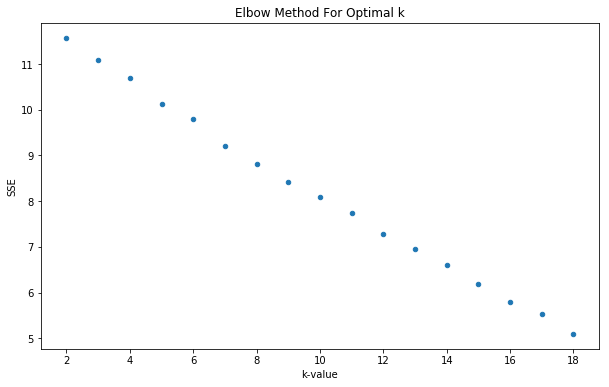

In [378]:
df_kcosts.plot(kind='scatter', x='k', y='SSE', figsize=(10, 6))
plt.ylabel('SSE')
plt.xlabel('k-value')
plt.title('Elbow Method For Optimal k')
plt.show()

Doesn't see a clear result. I try with 7 clusters

In [380]:
# set number of clusters
kclusters = 7

# run k-means clustering
kmeans = KMeans(init="k-means++", n_init=12, n_clusters=kclusters, random_state=10).fit(torontoFinal_grouped_clustering)

# check cluster labels generated for each row in the dataframe
kmeans.labels_[0:10] 

array([6, 3, 1, 1, 0, 1, 1, 2, 1, 5], dtype=int32)

Store clusters in a dataframe with the other information

In [381]:
# add clustering labels
neighborhoods_venues_sorted.insert(0, 'Cluster Labels', kmeans.labels_)

In [382]:
torontoFinal_merged = dfTorontoFinalCl

# merge toronto_grouped with toronto_data to add latitude/longitude for each neighborhood
torontoFinal_merged = torontoFinal_merged.join(neighborhoods_venues_sorted.set_index('Neighborhood'), on='Neighborhood')

torontoFinal_merged.head()


,PostalCode,Borough,Neighborhood,Latitude,Longitude,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
2,M5A,Downtown Toronto,"Harbourfront, Regent Park",43.654260,-79.360636,1,Coffee Shop,Café,Bakery,Mexican Restaurant,Breakfast Spot,Historic Site,Art Gallery,Italian Restaurant,Ice Cream Shop,French Restaurant
9,M5B,Downtown Toronto,"Ryerson, Garden District",43.657162,-79.378937,1,Coffee Shop,Clothing Store,Café,Cosmetics Shop,Middle Eastern Restaurant,Diner,Italian Restaurant,Japanese Restaurant,Bar,Department Store
15,M5C,Downtown Toronto,St. James Town,43.651494,-79.375418,3,Coffee Shop,Café,Hotel,Clothing Store,Italian Restaurant,Cosmetics Shop,Cocktail Bar,Bakery,Gastropub,Breakfast Spot
19,M4E,East Toronto,The Beaches,43.676357,-79.293031,1,Asian Restaurant,Coffee Shop,Music Venue,Concert Hall,Comfort Food Restaurant,College Rec Center,College Gym,College Arts Building,Cocktail Bar,Clothing Store
20,M5E,Downtown Toronto,Berczy Park,43.644771,-79.373306,3,Coffee Shop,Cocktail Bar,Farmers Market,Café,Cheese Shop,Bakery,Italian Restaurant,Beer Bar,Basketball Stadium,Jazz Club


Create map

In [383]:
# create map
map_clusters = folium.Map(location=[latitude, longitude], zoom_start=11)

# set color scheme for the clusters
x = np.arange(kclusters)
ys = [i + x + (i*x)**2 for i in range(kclusters)]
colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]

# add markers to the map
markers_colors = []
for lat, lon, poi, cluster in zip(torontoFinal_merged['Latitude'], torontoFinal_merged['Longitude'], torontoFinal_merged['Neighborhood'], torontoFinal_merged['Cluster Labels']):
    label = folium.Popup(str(poi) + ' Cluster ' + str(cluster))
    folium.CircleMarker(
        [lat, lon],
        radius=5,
        popup=label,
        color=rainbow[cluster-1],
        fill=True,
        fill_color=rainbow[cluster-1],
        fill_opacity=0.7).add_to(map_clusters)
       
map_clusters

## 6. Cluster Analysis

Calculate mean of venues frequency 

In [384]:
torontoFinal_grouped.insert(0, 'Cluster Labels', kmeans.labels_)

In [385]:
torontoFinal_average_cluster=torontoFinal_grouped.groupby('Cluster Labels').mean()

In [386]:
torontoFinal_average_cluster

,Adult Boutique,Afghan Restaurant,Airport,Airport Food Court,Airport Gate,Airport Lounge,Airport Service,Airport Terminal,American Restaurant,Antique Shop,...,Mexican Restaurant,Middle Eastern Restaurant,Miscellaneous Shop,Modern European Restaurant,Molecular Gastronomy Restaurant,Monument / Landmark,Movie Theater,Museum,Music Store,Music Venue
Cluster Labels,,,,,,,,,,,,,,,,,,,,,
0,0.000000,0.000000,0.076923,0.076923,0.076923,0.153846,0.153846,0.153846,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.00000,0.000000
1,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.008229,0.002382,...,0.007192,0.004816,0.000822,0.000822,0.000000,0.00037,0.004369,0.000000,0.00095,0.004573
2,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.030000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.00000,0.000000
3,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.010175,0.003509,...,0.000000,0.003333,0.000000,0.000000,0.006842,0.00000,0.006842,0.009569,0.00000,0.000000
4,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.015385,0.000000,...,0.000000,0.000000,0.015385,0.000000,0.000000,0.00000,0.000000,0.000000,0.00000,0.015385
5,0.011364,0.011364,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.011364,0.000000,...,0.011364,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.00000,0.000000
6,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.040000,0.000000,...,0.000000,0.000000,0.000000,0.002500,0.000000,0.00750,0.000000,0.007500,0.00000,0.000000


In Toronto you can have coffe everywhere... (I bet also in cluster0's Airport Food Court)

In [387]:
torontoFinal_average_cluster[['Coffee Shop']]

,Coffee Shop
Cluster Labels,
0,0.000000
1,0.071553
2,0.040000
3,0.079155
4,0.046154
5,0.056818
6,0.095000


If you like museums, then cluster 3 and 6 are the best

In [403]:
torontoFinal_average_cluster[['Museum']]

,Museum
Cluster Labels,
0,0.000000
1,0.000000
2,0.000000
3,0.009569
4,0.000000
5,0.000000
6,0.007500


### Some clusters characterization

Examine venues characterization of the cluster, based also on the neighborhoods positions on the map

#### Cluster 0

As can be seen from the map, cluster 0 is composed by the neighborhoods new the airport. It has all the venue related to the airport.

In [388]:
venue0=getVenuesList(torontoFinal_average_cluster,0)

In [389]:
venue0

array(['Airport', 'Airport Food Court', 'Airport Gate', 'Airport Lounge',
       'Airport Service', 'Airport Terminal', 'Boat or Ferry',
       'Harbor / Marina'], dtype=object)

#### Cluster 1

The cluster with more venues and with more neighbourhoods

In [390]:
venue1=getVenuesList(torontoFinal_average_cluster,1)

In [391]:
venue1

array(['American Restaurant', 'Antique Shop', 'Aquarium', 'Art Gallery',
       'Art Museum', 'Arts & Crafts Store', 'Asian Restaurant',
       'Auto Workshop', 'BBQ Joint', 'Baby Store', 'Bagel Shop', 'Bakery',
       'Bank', 'Bar', 'Baseball Stadium', 'Basketball Stadium',
       'Beer Bar', 'Beer Store', 'Bistro', 'Bookstore', 'Breakfast Spot',
       'Brewery', 'Bubble Tea Shop', 'Burger Joint', 'Burrito Place',
       'Bus Line', 'Butcher', 'Café', 'Cajun / Creole Restaurant',
       'Caribbean Restaurant', 'Cheese Shop', 'Chinese Restaurant',
       'Chocolate Shop', 'Climbing Gym', 'Clothing Store', 'Coffee Shop',
       'College Arts Building', 'College Gym', 'College Rec Center',
       'Comfort Food Restaurant', 'Comic Shop', 'Concert Hall',
       'Convenience Store', 'Cosmetics Shop', 'Coworking Space',
       'Cuban Restaurant', 'Dance Studio', 'Deli / Bodega',
       'Department Store', 'Dessert Shop', 'Dim Sum Restaurant', 'Diner',
       'Discount Store', 'Dog Run', 'Do

#### Cluster 2

In [392]:
venue2=getVenuesList(torontoFinal_average_cluster,2)

In [393]:
venue2

array(['Arepa Restaurant', 'Arts & Crafts Store', 'Bagel Shop', 'Bakery',
       'Bar', 'Beer Bar', 'Belgian Restaurant', 'Bistro',
       'Breakfast Spot', 'Brewery', 'Bubble Tea Shop', 'Burger Joint',
       'Burrito Place', 'Café', 'Caribbean Restaurant', 'Cheese Shop',
       'Chinese Restaurant', 'Cocktail Bar', 'Coffee Shop',
       'Comfort Food Restaurant', 'Dessert Shop', 'Dim Sum Restaurant',
       'Doner Restaurant', 'Donut Shop', 'Dumpling Restaurant',
       'Farmers Market', 'Filipino Restaurant', 'Fish & Chips Shop',
       'Fish Market', 'Food Court', 'Furniture / Home Store',
       'Gaming Cafe', 'Gourmet Shop', 'Grocery Store', 'Hospital',
       'Hotel Bar', 'Hotpot Restaurant', 'Ice Cream Shop',
       'Italian Restaurant', 'Japanese Restaurant', 'Jazz Club',
       'Liquor Store', 'Market', 'Martial Arts Dojo',
       'Mexican Restaurant'], dtype=object)

Having ChinaTown, it is the one with more chinese restaurant

In [394]:
torontoFinal_average_cluster[['Chinese Restaurant']]

,Chinese Restaurant
Cluster Labels,
0,0.000000
1,0.006546
2,0.030000
3,0.000000
4,0.000000
5,0.011364
6,0.000000


#### Cluster 3

In [395]:
venue3=getVenuesList(torontoFinal_average_cluster,3)

In [396]:
venue3

array(['American Restaurant', 'Antique Shop', 'Art Gallery', 'BBQ Joint',
       'Bagel Shop', 'Bakery', 'Bank', 'Basketball Stadium', 'Beach',
       'Beer Bar', 'Belgian Restaurant', 'Bistro', 'Bookstore',
       'Breakfast Spot', 'Café', 'Cheese Shop', 'Church',
       'Clothing Store', 'Cocktail Bar', 'Coffee Shop',
       'Comfort Food Restaurant', 'Concert Hall', 'Cosmetics Shop',
       'Creperie', 'Deli / Bodega', 'Department Store', 'Diner',
       'Electronics Store', 'Farmers Market', 'Fast Food Restaurant',
       'Fish Market', 'Food Truck', 'Fountain', 'French Restaurant',
       'Furniture / Home Store', 'Gastropub', 'German Restaurant',
       'Greek Restaurant', 'Grocery Store', 'Gym', 'Hostel', 'Hotel',
       'Ice Cream Shop', 'Indian Restaurant', 'Irish Pub',
       'Italian Restaurant', 'Japanese Restaurant', 'Jazz Club',
       'Korean Restaurant', 'Latin American Restaurant', 'Liquor Store',
       'Lounge', 'Middle Eastern Restaurant',
       'Molecular Gastrono

#### Cluster 4

In [397]:
venue4=getVenuesList(torontoFinal_average_cluster,4)

In [398]:
venue4

array(['American Restaurant', 'Art Gallery', 'Asian Restaurant', 'Bakery',
       'Bar', 'Bistro', 'Boutique', 'Brewery', 'Café', 'Cocktail Bar',
       'Coffee Shop', 'Cuban Restaurant', 'Cupcake Shop', 'Diner',
       'Dog Run', 'French Restaurant', 'Gift Shop', 'Greek Restaurant',
       'Gym / Fitness Center', 'Ice Cream Shop', 'Italian Restaurant',
       'Juice Bar', 'Korean Restaurant', 'Mac & Cheese Joint',
       'Malay Restaurant', "Men's Store", 'Miscellaneous Shop',
       'Music Venue'], dtype=object)

#### Cluster 5

It is composed by Church and Wellesle, also known as The Village, because it contains a gay community. It is also famous for its night life.

In [399]:
venue5=getVenuesList(torontoFinal_average_cluster,5)

In [400]:
venue5

array(['Adult Boutique', 'Afghan Restaurant', 'American Restaurant',
       'Arts & Crafts Store', 'Bar', 'Bookstore', 'Breakfast Spot',
       'Bubble Tea Shop', 'Burger Joint', 'Burrito Place', 'Café',
       'Caribbean Restaurant', 'Chinese Restaurant', 'Coffee Shop',
       'Cosmetics Shop', 'Creperie', 'Dance Studio', 'Diner', 'Dog Run',
       'Ethiopian Restaurant', 'Fast Food Restaurant',
       'Food & Drink Shop', 'Gastropub', 'Gay Bar',
       'General Entertainment', 'Grocery Store', 'Gym',
       'Health & Beauty Service', 'Hobby Shop', 'Hotel', 'Ice Cream Shop',
       'Indian Restaurant', 'Japanese Restaurant', 'Juice Bar',
       'Mediterranean Restaurant', "Men's Store", 'Mexican Restaurant'],
      dtype=object)

#### Cluster 6

In [401]:
venue6=getVenuesList(torontoFinal_average_cluster,6)

In [402]:
venue6

array(['American Restaurant', 'Art Gallery', 'Art Museum',
       'Asian Restaurant', 'Bakery', 'Bar', 'Basketball Stadium',
       'Beer Bar', 'Bookstore', 'Brazilian Restaurant', 'Breakfast Spot',
       'Building', 'Burger Joint', 'Burrito Place', 'Café',
       'Clothing Store', 'Cocktail Bar', 'Coffee Shop', 'Concert Hall',
       'Cosmetics Shop', 'Creperie', 'Deli / Bodega', 'Department Store',
       'Electronics Store', 'Fast Food Restaurant', 'Food Court',
       'Food Truck', 'Fountain', 'French Restaurant',
       'Fried Chicken Joint', 'Gastropub', 'General Travel',
       'Gluten-free Restaurant', 'Greek Restaurant', 'Gym',
       'Gym / Fitness Center', 'Hotel', 'Hotel Bar', 'Ice Cream Shop',
       'Indian Restaurant', 'Irish Pub', 'Italian Restaurant',
       'Japanese Restaurant', 'Jazz Club', 'Lounge',
       'Mediterranean Restaurant', 'Modern European Restaurant',
       'Monument / Landmark', 'Museum'], dtype=object)